In [1]:
from scmodels import SCM
import random, math

In [21]:
def get_distributions():
    ep = .1
    dists = [
        f"LogLogistic(alpha={random.randint(5, 20)}, beta={round(random.uniform(1,3.5),1)})",
        f"Normal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"LogNormal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"Benini(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)}, sigma={round(random.random() + ep, 1)})",
        f"Beta(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)})",
        f"Exponential(rate={round((random.random() + ep) * 10, 1)})",
        f"FDistribution(d1={random.randint(2, 4)}, d2={random.randint(5, 8)})",
        f"Gamma(k={round((random.random() + ep) * 4, 1)}, theta={round((random.random() + ep) * 8, 1)})",
        f"GammaInverse(a={round((random.random() + ep) * 4, 1)}, b={round((random.random() + ep) * 8, 1)})",
        f"Bernoulli({round(random.random(), 1)})",
        f"Binomial(n={random.randint(2, 10)}, p={round(random.random(), 1)}, succ={random.randint(3, 20)}, fail={random.randint(3, 20)})",
        f"BetaBinomial(n={random.randint(10, 100)}, alpha={round(random.random(), 1)}, beta={round(random.uniform(2, 5),1)})",
        f"Die(sides={random.randint(4, 10)})",
        f"DiscreteUniform(items='1 2 3')",
        f"Geometric(p={round(random.random(), 2)})",
        f"Poisson(lamda={round(random.random() + ep, 1)})",
        f"FiniteRV({{{random.randint(5, 10)}: 1/2, {random.randint(0, 3)}: 1/6, {random.randint(15, 25)}: 1/6, {random.randint(30, 50)}: 1/6}})"
    ]
    
    return dists

In [22]:
def get_child_distribution(parents):
    simple_ops = ["+", "*", "-"]
    complex_ops = [False, "sqrt"]
    noise_ops = [True, False]
    dist = f"{parents[0]}"
    count = 0
    for p in parents[1:]:
        op = random.sample(simple_ops, 1)[0]
        dist = f"{dist} {op} {p}"
        count += 1
        
        if count > 2:
            op = random.choices(complex_ops, weights=(500, 5), k=1)[0]
            if op:
                dist = f"{op}({dist})"
        
        op = random.choices(noise_ops, weights=(10, 90), k=1)[0]
        if op:
            dist = f"{dist} * N"
    
    dist = f"{dist} * N"
    return dist

In [23]:
def get_parents(levels_and_distributions):
    parent_levels = random.randint(1,len(levels_and_distributions))
    parents = []
    for level in range(parent_levels):
        possible_parents = levels_and_distributions[level][1]
        num_parents = random.randint(1, len(possible_parents))
        parents.extend(random.sample(possible_parents, num_parents))
    
    return parents

In [24]:
def get_level_n_distributions(level_data, levels_and_distributions):
    level_dists = []
    dist_names = []
    for n in range(level_data['num']):
        name = level_data['name']+str(n+1)
        dist = get_child_distribution(get_parents(levels_and_distributions))
        dist = f"{name} = {dist}, N ~ {random.sample(get_distributions(), 1)[0]}"

        level_dists.append(dist)
        dist_names.append(name)
    
    return level_dists, dist_names

In [25]:
def get_level_0_distributions(level_data):
    level_dists = []
    dist_names = []
    for n in range(level_data['num']):
        name = level_data['name']+str(n+1)
        dist = f"{name} = N, N ~ {random.sample(get_distributions(), 1)[0]}"
        level_dists.append(dist)
        dist_names.append(name)
    
    return level_dists, dist_names

In [26]:
def populate_level_distributions(level, level_data, levels_and_distributions):
    if level == 0:
        levels_and_distributions[level] = get_level_0_distributions(level_data)
    else:
        levels_and_distributions[level] = get_level_n_distributions(level_data, levels_and_distributions)

In [27]:
def create_names_and_num_nodes_dict(nodes_per_level, level_names):
    level_name_numnodes = {}
    for n, name in enumerate(level_names):
        level_name_numnodes[n] = {'name': name, 'num': nodes_per_level[n]}
        
    return level_name_numnodes

In [28]:
def create_scm_from_nodes_list(nodes_list):
    level_names = get_level_names(nodes_per_level)
    level_name_numnodes = create_names_and_num_nodes_dict(nodes_per_level, level_names)

In [29]:
def get_level_names(numnodes_per_level):
    level_names = []
    for n in range(len(numnodes_per_level)):
        level_names.append(chr(65 + n))
    
    return level_names

In [30]:
def get_numnodes_per_level(input_nodes):
    nodes = input_nodes
    levels = int(math.pow(nodes, 1/3))
    numnodes_per_level = []
    for n in range(levels):
        ub = round(math.log(nodes)) - 0.6
        lb = ub - 0.7
        level_nodes = int(math.exp(round(random.uniform(lb,ub), 1)))
        if level_nodes == 0 : break

        numnodes_per_level.append(level_nodes)
        nodes -= level_nodes
        
    return numnodes_per_level

In [31]:
def create_scm(level_name_numnodes):
    levels_and_distributions = {}
    for level, level_data in level_name_numnodes.items():
        populate_level_distributions(level, level_data, levels_and_distributions)


    scm_dists = levels_and_distributions[0][0]
    for n in range(1, len(levels_and_distributions)):
        scm_dists.extend(levels_and_distributions[n][0])
    
    scm = SCM(
        scm_dists
    )
    
    return scm

In [32]:
def create_scm_from_nodes_list(nodes_list):
    level_names = get_level_names(nodes_list)
    level_name_numnodes = create_names_and_num_nodes_dict(nodes_list, level_names)
    
    scm = create_scm(level_name_numnodes)
    return scm

In [33]:
def create_scm_from_num_nodes(input_nodes):
    nodes_list = get_numnodes_per_level(input_nodes)
    scm = create_scm_from_nodes_list(nodes_list)
    return scm

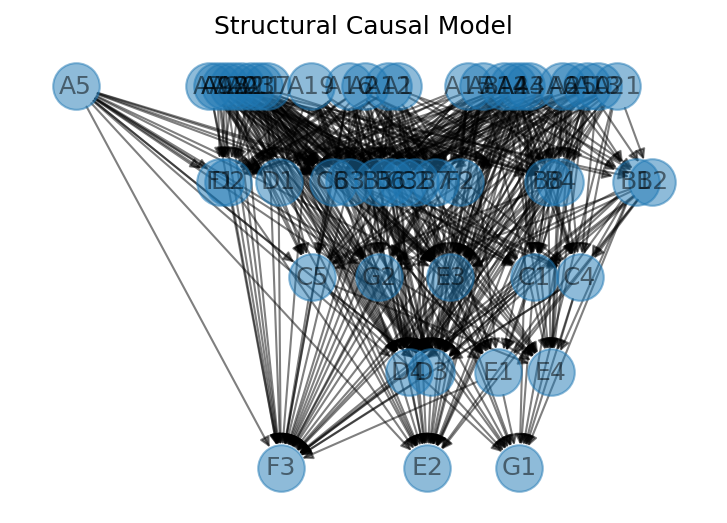

In [36]:
input_nodes = [25, 8, 6, 4, 4, 3, 2]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot();

In [35]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float
<lambdifygenerated-325>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(A1*A22*N - A10*A23*N + A13 - A14*A21 + A15 - A17*A8 + A18 + A19 + A2 - A4 - A5 + A7 - A9)*N**2
<lambdifygenerated-331>:2: RuntimeWarning: invalid value encountered in sqrt
  return -B2*B7 - B3*B4*N - B5 + B6*sqrt(A13*B8 + A15*A17*A7 + A16*A5*N + A18 - A24 - A25 - A3 + A4)


A1        A2   A3         A4        A5         A6    A7        A8  \
0   0.201745  0.380923  3.0  35.345659  0.323725 -10.672380  25.0  0.052179   
1   0.088495  0.637406  2.0   9.547445  0.003392  14.159791  25.0  1.103698   
2   0.265398  0.823510  3.0 -32.358467  0.899465  25.572749  35.0  0.822419   
3   0.066480  0.837385  1.0 -11.543142  0.595558  14.764966  30.0  1.229366   
4   0.012774  0.621484  1.0   4.934289  0.617850   1.679226  30.0  0.689727   
..       ...       ...  ...        ...       ...        ...   ...       ...   
95  0.167440  0.624665  3.0  18.672872  0.674985  28.895481  35.0  1.531526   
96  0.001517  0.954553  2.0   4.682365  0.075745   2.540798  25.0  1.333754   
97  0.045710  0.999790  2.0 -25.059954  0.181393   4.875606  30.0  1.167703   
98  0.075262  0.035714  3.0  -9.753202  0.099550   9.838413  35.0  0.312321   
99  0.324145  0.070929  2.0   8.011442  0.555605  15.777314  35.0  0.609043   

     A9  A10  ...          E4            E3            C1            F3  \
0   3.0  0.0  ... -125.023109  14366.076201           NaN -1.207744e+09   
1   6.0  2.0  ...  -74.367652           NaN           NaN           NaN   
2   5.0  0.0  ... -405.924751   5942.971804 -1.358467e+06 -7.539964e+03   
3   2.0  1.0  ...  214.314270           NaN           NaN           NaN   
4   1.0  0.0  ... -136.949947  17597.947357           NaN -2.327391e+05   
..  ...  ...  ...         ...           ...           ...           ...   
95  4.0  0.0  ...  -55.811977           NaN           NaN           NaN   
96  1.0  0.0  ...  -91.205928  52295.745463           NaN -8.561818e+09   
97  1.0  0.0  ... -198.713109   2369.986772 -1.161989e+07  2.271630e+04   
98  1.0  0.0  ... -124.062238   3824.529420 -2.991962e+08  4.766357e+10   
99  2.0  0.0  ...  -21.578564   5567.852191           NaN -6.977408e+06   

              F1            D2            D3            G1            F2  \
0   1.594890e+09           NaN           NaN           NaN           NaN   
1   1.086431e+08           NaN           NaN           NaN           NaN   
2   1.709195e+09 -7.595017e+13 -1.170696e+07 -7.179690e+10 -7.590009e+13   
3   6.281078e+08           NaN           NaN           NaN           NaN   
4   3.340777e+09           NaN           NaN           NaN           NaN   
..           ...           ...           ...           ...           ...   
95  4.627947e+09           NaN           NaN           NaN           NaN   
96 -5.838704e+08           NaN           NaN           NaN           NaN   
97  2.941349e+08  7.938172e+13 -1.677112e+07 -2.777014e+09  7.957193e+13   
98  6.833256e+07  8.438493e+14 -3.000279e+08 -2.529722e+11  8.437912e+14   
99  5.372201e+08           NaN           NaN           NaN           NaN   

              G2  
0            NaN  
1            NaN  
2   7.478402e+20  
3            NaN  
4            NaN  
..           ...  
95           NaN  
96           NaN  
97  8.446504e+18  
98 -9.814448e+21  
99           NaN  

[100 rows x 52 columns]